# Distributed modeling with static schedule
We demonstrate using two workers to model 4 shots across Marmousi with a static distribution.

In [1]:
using Distributed, PyPlot

In [2]:
addprocs(2)

2-element Array{Int64,1}:
 2
 3

In [3]:
@everywhere using DistributedArrays, DistributedJets, Jets, WaveFD, JetPackWaveFD, Random

In [4]:
v = read!("../02_marmousi_model_setup/marmousi_vp_20m_176x851.bin", Array{Float32}(undef, 176,851));
dz,dx = 20.0,20.0
nz,nx = size(v)
@show dz,dx
@show nz,nx;

(dz, dx) = (20.0, 20.0)
(nz, nx) = (176, 851)


In [5]:
sx = range(0,length=4,stop=(851-1)*20)
nshots = length(sx)
@show nshots;

nshots = 4


## Note on scratch space for temporary files
When dealing with multiple shots as in this example, we need to specify the location where scratch files will be written.

You will need to change this to point to a temporary directory available on your system.

In [6]:
@everywhere scratch = "/mnt/scratch"
@assert isdir(scratch)

In [7]:
@everywhere function makeF(i,sx)
    nz,nx,dz,dx = 176,851,20.0,20.0    
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = 1601,
        dtrec = 0.004,
        dtmod = 0.002,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=5.0),
        sx = sx[i],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        srcfieldfile = joinpath(scratch, "field-$i.$(randstring()).bin"),
        reportinterval=1000)
end

In [8]:
F = @blockop DArray(I->[makeF(i,sx) for i in I[1], j in I[2]], (nshots,1))

"Jet nonlinear operator, (176, 851) → (5449804,)"

In [9]:
d = F*v;

[ Info: nonlinear forward on cbox-wask-HB60rs, srcfieldfile=/mnt/scratch/field-3.0INXN3fb.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step     1 of  3201 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%) -- rms d,p; 0.0000e+00 0.0000e+00
[ Info: nonlinear forward on cbox-wask-HB60rs, srcfieldfile=/mnt/scratch/field-1.C4tMqJOy.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step     1 of  3201 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%) -- rms d,p; 0.0000e+00 0.0000e+00
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1000 of  3201 ;  114.03 MCells/s (IO=40.57%, EX=21.18%) -- rms d,p; 9.6169e-01 7.7778e-01
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1000 of  3201 ;   79.90 MCells/s (IO=31.59%, EX=33.49%) -- rms d,p; 1.3196e+00 9.9564e-01
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  2000 of  3201 ;  142.27 MCells/s (IO=47.99%, EX=23.11%) -- rms d,p; 1.0639e+00 3.0163e-01
[ Info: Prop2DAcoIsoDenQ_DEO2_FD

## Plot the shots

In [29]:
# fetch shot gathers from the `DArray` distributed on the workers
shots = [getblock(d, i) for i in 1:nshots];

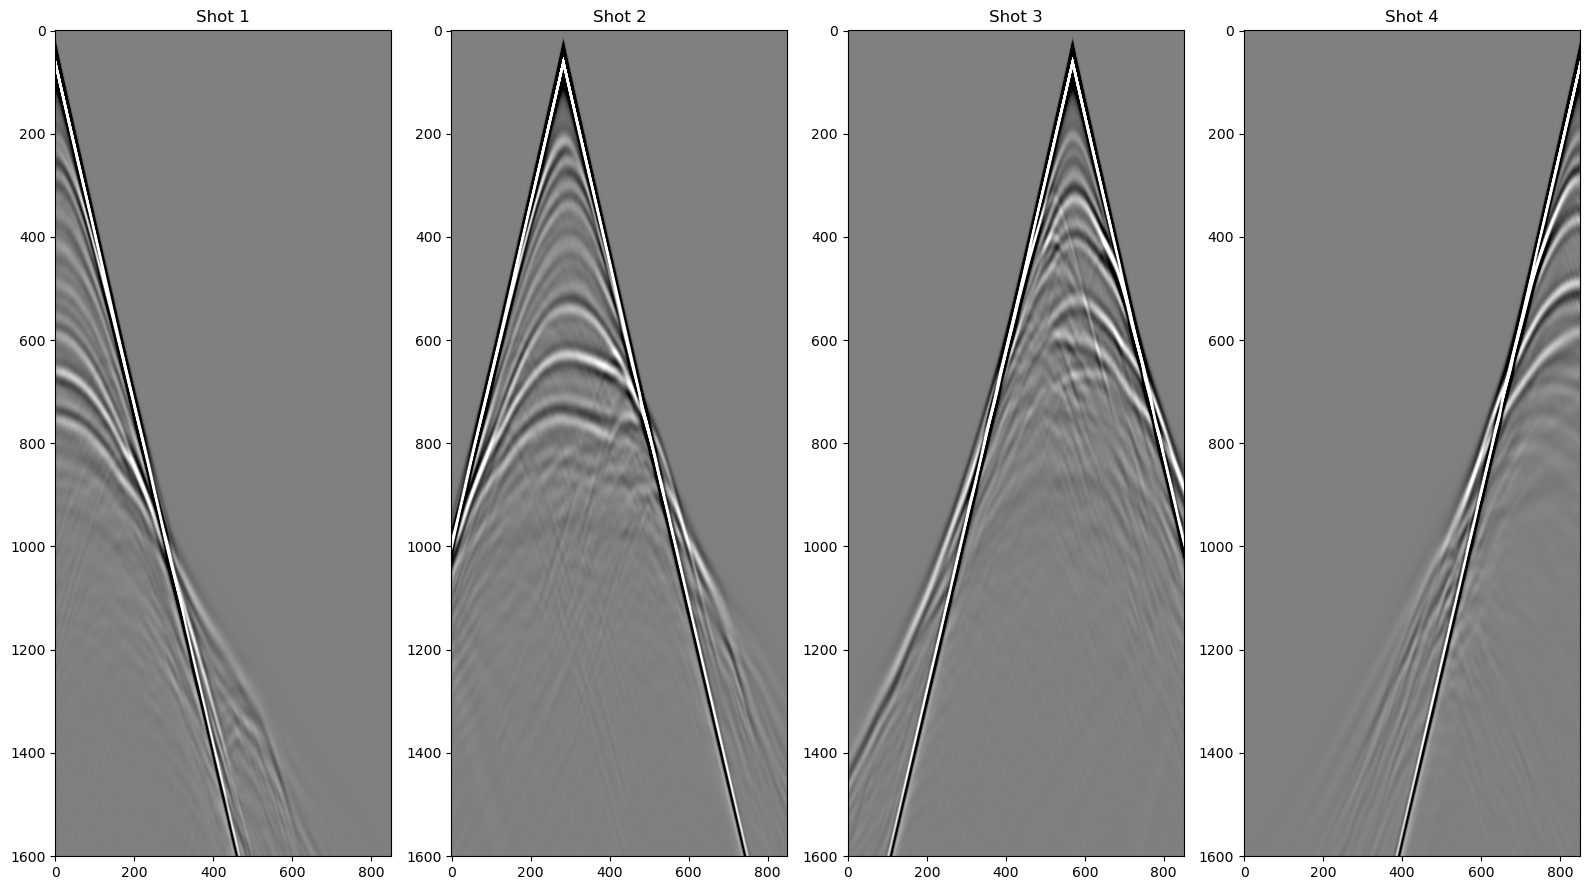

In [30]:
dmax = maximum(abs, extrema(d))
figure(figsize=(16,9)); clf()
for k in 1:nshots
    subplot(1,4,k)
    imshow(shots[k], aspect="auto", cmap="gray")
    clim(0.025 .* [-dmax,+dmax])
    title("Shot $(k)")
end
tight_layout()
nothing

## Remove source field files on local disk

In [12]:
# close(F)

## Remove workers

In [13]:
# rmprocs(workers())